In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
# import pmdarima as pm

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import time
import warnings
import gc

import datetime

pd.set_option('display.max_columns', None)
plt.style.use(style = 'seaborn')

warnings.filterwarnings('ignore')

In [ ]:
%%time
px_18 = pd.read_csv('/content/drive/MyDrive/Paycheck Project/FY18 PX Clients - Monthly Rev Buckets.csv')
px_19 = pd.read_csv('/content/drive/MyDrive/Paycheck Project/FY19 PX Clients - Monthly Rev Buckets.csv')
px_20 = pd.read_csv('/content/drive/MyDrive/Paycheck Project/FY20 PX Clients - Monthly Rev Buckets.csv')
px_21 = pd.read_csv('/content/drive/MyDrive/Paycheck Project/FY21 PX Clients - Monthly Rev Buckets.csv')
px_22 = pd.read_csv('/content/drive/MyDrive/Paycheck Project/FY22 PX Clients - Monthly Rev Buckets.csv')


CPU times: user 22.3 s, sys: 2.65 s, total: 24.9 s
Wall time: 32 s


In [ ]:
px_22

,UNIQUESYSTEMCLIENTID,EECOUNT,BUSTYPELEVEL1,PRSTATUS,ZIPCODE,STATECODE,LENGTHOFSERVICE,FIRSTPRRUNDATE,LASTPRRUNDATE,MONTHSWITHREVENUE,JUNE21TOTALREV,JUNE21PAYROLLREVENUE,JUNE21PEOREVENUE,JUNE21ASOREVENUE,JUNE21TIMEREVENUE,JUNE21RETIREMENTREVENUE,JUNE21HNBREVENUE,JUNE21WRKRSCOMPREVENUE,JUNE21PRODUCTCOUNT,JULY21TOTALREV,JULY21PAYROLLREVENUE,JULY21PEOREVENUE,JULY21ASOREVENUE,JULY21TIMEREVENUE,JULY21RETIREMENTREVENUE,JULY21HNBREVENUE,JULY21WRKRSCOMPREVENUE,JULY21PRODUCTCOUNT,AUG21TOTALREV,AUG21PAYROLLREVENUE,AUG21PEOREVENUE,AUG21ASOREVENUE,AUG21TIMEREVENUE,AUG21RETIREMENTREVENUE,AUG21HNBREVENUE,AUG21WRKRSCOMPREVENUE,AUG21PRODUCTCOUNT,SEPT21TOTALREV,SEPT21PAYROLLREVENUE,SEPT21PEOREVENUE,SEPT21ASOREVENUE,SEPT21TIMEREVENUE,SEPT21RETIREMENTREVENUE,SEPT21HNBREVENUE,SEPT21WRKRSCOMPREVENUE,SEPT21PRODUCTCOUNT,OCT21TOTALREV,OCT21PAYROLLREVENUE,OCT21PEOREVENUE,OCT21ASOREVENUE,OCT21TIMEREVENUE,OCT21RETIREMENTREVENUE,OCT21HNBREVENUE,OCT21WRKRSCOMPREVENUE,OCT21PRODUCTCOUNT
0,2665440,1,Administrative and Support and Waste Managemen...,Active,28801,NC,56.90,2016-12-30,2021-09-27,4,63.89,63.52,nan,nan,nan,nan,nan,nan,4.00,82.59,82.22,nan,nan,nan,nan,nan,nan,5.00,63.89,63.52,nan,nan,nan,nan,nan,nan,4.00,63.89,63.52,nan,nan,nan,nan,nan,nan,4.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2212011,18,Construction,Active,27407,NC,5.10,2021-04-27,2021-09-27,4,548.76,498.04,nan,nan,nan,nan,nan,nan,6.00,557.72,503.65,nan,nan,nan,nan,nan,nan,7.00,551.25,507.51,nan,nan,nan,nan,nan,nan,6.00,551.25,507.51,nan,nan,nan,nan,nan,nan,6.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2740121,1,Wholesale Trade,Active,90049,CA,46.00,2017-11-28,2021-09-28,4,74.14,73.95,nan,nan,nan,nan,nan,nan,4.00,397.67,396.88,nan,nan,nan,nan,nan,nan,5.00,78.25,78.05,nan,nan,nan,nan,nan,nan,4.00,312.97,312.18,nan,nan,nan,nan,nan,nan,4.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,2377900,1,Manufacturing,Active,17777,PA,13.10,2020-08-26,2021-08-25,4,51.53,0.00,nan,49.63,nan,nan,nan,nan,4.00,51.45,15.40,nan,34.78,nan,nan,nan,nan,5.00,36.05,0.00,nan,34.78,nan,nan,nan,nan,4.00,286.00,nan,nan,286.00,nan,nan,nan,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2885348,1,Real Estate and Rental and Leasing,Active,10553,NY,28.80,2019-05-07,2021-09-29,4,218.09,217.15,nan,nan,nan,nan,nan,nan,3.00,183.92,183.13,nan,nan,nan,nan,nan,nan,3.00,183.92,183.13,nan,nan,nan,nan,nan,nan,3.00,229.90,228.91,nan,nan,nan,nan,nan,nan,3.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483519,2569675,21,"Arts, Entertainment, and Recreation",Active,85250,AZ,68.40,2016-01-14,2021-09-22,4,247.50,246.87,nan,nan,nan,nan,nan,nan,3.00,287.10,286.44,nan,nan,nan,nan,nan,nan,5.00,101.20,100.10,nan,nan,nan,nan,nan,nan,3.00,303.60,300.96,nan,nan,nan,nan,nan,nan,3.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
483520,2570804,9,Construction,Active,06360,CT,37.20,2018-08-21,2021-09-29,4,520.55,459.79,nan,nan,nan,nan,nan,nan,5.00,434.45,384.50,nan,nan,nan,nan,nan,nan,6.00,443.18,391.56,nan,nan,nan,nan,nan,nan,5.00,572.58,506.02,nan,nan,nan,nan,nan,nan,5.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
483521,449965,4,Retail Trade,Active,08106,NJ,296.90,1996-12-16,2021-09-27,4,191.40,189.73,nan,nan,nan,nan,nan,nan,3.00,228.80,227.04,nan,nan,nan,nan,nan,nan,5.00,202.40,200.64,nan,nan,nan,nan,nan,nan,3.00,303.60,300.96,nan,nan,nan,nan,nan,nan,3.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
483522,950636,7,"Professional, Scientific, and Technical Services",Active,33401,FL,184.40,2006-05-09,2021-09-22,4,667.11,429.98,nan,nan,nan,207.65,nan,nan,11.00,486.13,254.27,nan,nan,nan,208.54,nan,nan,11.00,512.43,276.06,nan,nan,nan,209.53,nan,nan,11.00,503.44,269.02,nan,nan,nan,210.22,nan,nan,10.00,nan,nan,nan,nan,nan,nan,nan,nan,nan


Create Revenue donut plot function

In [ ]:
def revenue_plot(df, pie_title):
  strings = df.columns.tolist()
  #Total Revenue 
  total_cols = [string for string in strings if "TOTALREV" in string]
  #PAYROLLREV
  payroll_cols = [string for string in strings if "PAYROLLREV" in string]
  #PEOREV
  peo_cols = [string for string in strings if "PEOREV" in string]
  #ASOREV
  aso_cols = [string for string in strings if "ASOREV" in string]
  #TIMEREV
  timer_cols = [string for string in strings if "TIMEREV" in string]
  #RETIREMENTREV
  retire_cols = [string for string in strings if "RETIREMENTREV" in string]
  #HNBREV
  hnb_cols = [string for string in strings if "HNBREV" in string]
  #WRKRSCOMPREV
  wrkscomp_cols = [string for string in strings if "WRKRSCOMPREV" in string]

  other = df[total_cols].sum().sum() - 
          (df[payroll_cols].sum().sum()+df[peo_cols].sum().sum()+df[aso_cols].sum().sum() 
          + df[timer_cols].sum().sum()+df[retire_cols].sum().sum()+df[hnb_cols].sum().sum()
          +df[wrkscomp_cols].sum().sum())
  rev_percentage = [df[payroll_cols].sum().sum(), df[peo_cols].sum().sum(), 
                    df[aso_cols].sum().sum(), df[timer_cols].sum().sum(),
            df[retire_cols].sum().sum(), df[hnb_cols].sum().sum(), 
            df[wrkscomp_cols].sum().sum(), other]
  label = ['Payroll', 'PEO', 'ASO', 'Timer','Retire', 'H&B', 'WorkComp', 'Others']
  colours = dict(zip(label, plt.cm.Set2.colors[:len(label)]))
  explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)
  # fig = plt.figure(figsize =(6, 6))
  plt.title(pie_title, fontdict = {'fontsize' : 20})
  plt.pie(rev_percentage, labels = label, autopct='%1.0f%%', textprops={'fontsize': 14}, 
          colors=[colours[key] for key in label], shadow=True, pctdistance=0.85, 
          explode=explode)

  #draw circle
  centre_circle = plt.Circle((0,0),0.70,fc='white')
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)

  plt.tight_layout()
  plt.show()


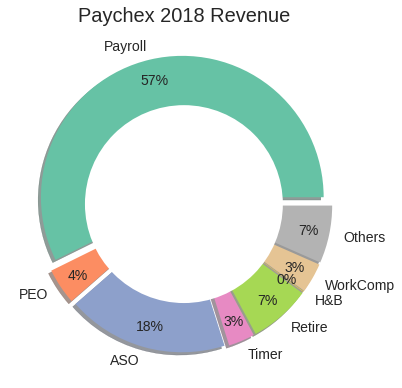

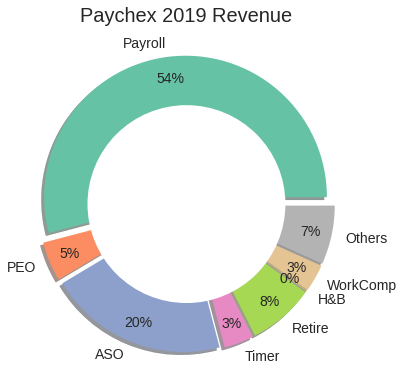

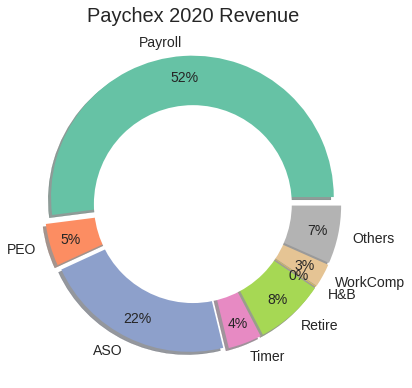

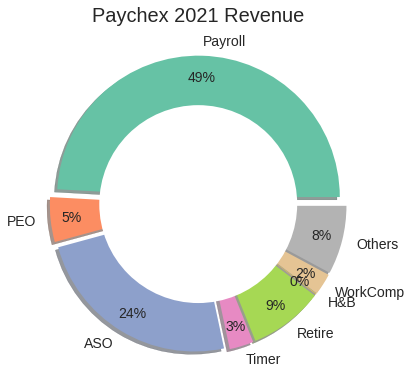

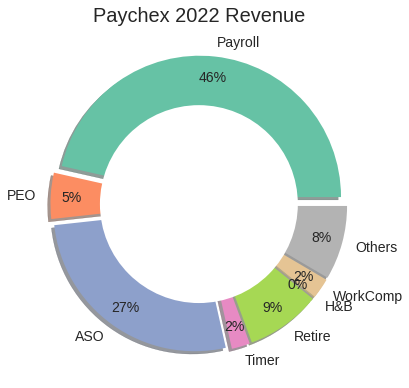

In [ ]:
revenue_plot(px_18, 'Paychex 2018 Revenue'),
revenue_plot(px_19, 'Paychex 2019 Revenue'),
revenue_plot(px_20, 'Paychex 2020 Revenue'),
revenue_plot(px_21, 'Paychex 2021 Revenue'),
revenue_plot(px_22, 'Paychex 2022 Revenue')

Create table of revenue to verify the pie plot

In [ ]:
def revenue_table(df):
  strings = df.columns.tolist()
  #Total Revenue 
  total_cols = [string for string in strings if "TOTALREV" in string]
  #PAYROLLREV
  payroll_cols = [string for string in strings if "PAYROLLREV" in string]
  #PEOREV
  peo_cols = [string for string in strings if "PEOREV" in string]
  #ASOREV
  aso_cols = [string for string in strings if "ASOREV" in string]
  #TIMEREV
  timer_cols = [string for string in strings if "TIMEREV" in string]
  #RETIREMENTREV
  retire_cols = [string for string in strings if "RETIREMENTREV" in string]
  #HNBREV
  hnb_cols = [string for string in strings if "HNBREV" in string]
  #WRKRSCOMPREV
  wrkscomp_cols = [string for string in strings if "WRKRSCOMPREV" in string]

  other = df[total_cols].sum().sum() - (df[payroll_cols].sum().sum()+df[peo_cols].sum().sum()+df[aso_cols].sum().sum() 
   +df[timer_cols].sum().sum()+df[retire_cols].sum().sum()+df[hnb_cols].sum().sum()
   +df[wrkscomp_cols].sum().sum())
  rev_by_category = [df[total_cols].sum().sum(), df[payroll_cols].sum().sum(), 
                     df[peo_cols].sum().sum(), df[aso_cols].sum().sum(), 
            df[timer_cols].sum().sum(), df[retire_cols].sum().sum(), 
            df[hnb_cols].sum().sum(), df[wrkscomp_cols].sum().sum(),
            other]
  label = ['Total', 'Payroll', 'PEO', 'ASO', 'Time','Retire', 'H&B', 'WorkComp', 'Others']
  return rev_by_category


In [ ]:
table_rev = pd.DataFrame(
    columns=['Total', 'Payroll', 'PEO', 'ASO', 'Time','Retire', 'H&B', 'WorkComp', 'Others'],
     index=[2018, 2019, 2020, 2021, 2022])
table_rev.loc[2018] = revenue_table(px_18)
table_rev.loc[2019] = revenue_table(px_19)
table_rev.loc[2020] = revenue_table(px_20)
table_rev.loc[2021] = revenue_table(px_21)
table_rev.loc[2022] = revenue_table(px_22)
# Add percentage for convenience
table_rev['Payroll %'] = table_rev['Payroll']/table_rev['Total']
table_rev['PEO %'] = table_rev['PEO']/table_rev['Total']
table_rev['ASO %'] = table_rev['ASO']/table_rev['Total']
table_rev['Time %'] = table_rev['Time']/table_rev['Total']
table_rev['Retire %'] = table_rev['Retire']/table_rev['Total']
table_rev['H&B %'] = table_rev['H&B']/table_rev['Total']
table_rev['WorkComp %'] = table_rev['WorkComp']/table_rev['Total']
table_rev['Others %'] = table_rev['Others']/table_rev['Total']
pd.options.display.float_format = '{:,.2f}'.format
table_rev

,Total,Payroll,PEO,ASO,Time,Retire,H&B,WorkComp,Others,Payroll %,PEO %,ASO %,Time %,Retire %,H&B %,WorkComp %,Others %
2018,"2,734,250,845.81","1,566,818,485.78","112,854,040.38","503,996,477.16","82,235,428.59","192,492,986.20","1,594,310.57","93,887,451.85","180,371,665.28",0.57,0.04,0.18,0.03,0.07,0.00,0.03,0.07
2019,"2,933,905,246.84","1,586,636,458.98","132,077,644.80","601,328,614.67","99,574,828.70","221,819,616.05","1,666,429.15","92,923,027.41","197,878,627.08",0.54,0.05,0.20,0.03,0.08,0.00,0.03,0.07
2020,"3,081,235,031.37","1,602,975,355.26","149,075,390.19","676,169,772.68","118,244,265.48","244,461,174.97","1,968,858.14","83,614,347.44","204,725,867.21",0.52,0.05,0.22,0.04,0.08,0.00,0.03,0.07
2021,"3,222,454,563.17","1,582,961,452.64","164,726,746.46","776,972,658.56","88,825,417.29","274,037,492.36","1,777,466.34","80,147,576.12","253,005,753.40",0.49,0.05,0.24,0.03,0.09,0.00,0.02,0.08
2022,"1,195,360,584.77","555,561,526.10","62,812,104.25","320,262,975.12","25,052,738.19","102,187,736.00","415,969.11","27,846,328.38","101,221,207.62",0.46,0.05,0.27,0.02,0.09,0.00,0.02,0.08


In [ ]:
table_rev[['Payroll %', 'PEO %', 'ASO %', 'Time %', 'Retire %', 'H&B %', 'WorkComp %', 'Others %']].bar()

Text(0.5, 1.0, 'Paychex Revenue')

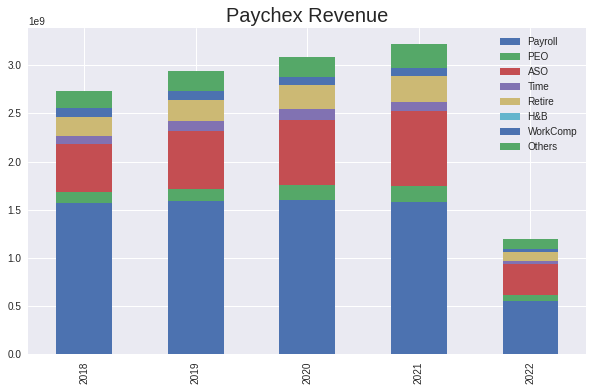

In [ ]:

table_rev[['Payroll', 'PEO', 'ASO', 'Time', 'Retire', 'H&B', 'WorkComp', 'Others']].plot.bar(stacked=True, figsize =(10, 6))
plt.title('Paychex Revenue', fontdict = {'fontsize' : 20})


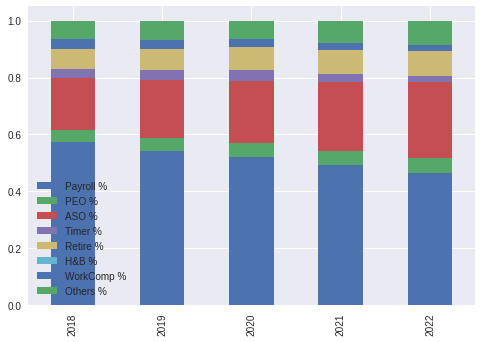

In [ ]:
table_rev[['Payroll %', 'PEO %', 'ASO %', 'Timer %', 'Retire %', 'H&B %', 'WorkComp %', 'Others %']].plot.bar(stacked=True)

In [ ]:
del px_18, px_19, px_20, px_21, px_22
gc.collect()

12800

Paychex's ASO revenue increases year by year along with total revnue and payroll revenue's increasing.

Industry 

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
px_total.head(3)

,UNIQUESYSTEMCLIENTID,EECOUNT,BUSTYPELEVEL1,PRSTATUS,STATECODE,LENGTHOFSERVICE,FIRSTPRRUNDATE,LASTPRRUNDATE,MONTHSWITHREVENUE,Month,TOTALREV
0,9970,27,"Professional, Scientific, and Technical Services",Active,MA,207.90,2004-05-21,2021-09-22,12,2017-06-01,188.37
1,9970,27,"Professional, Scientific, and Technical Services",Active,MA,207.90,2004-05-21,2021-09-22,12,2017-07-01,200.47
2,9970,27,"Professional, Scientific, and Technical Services",Active,MA,207.90,2004-05-21,2021-09-22,12,2017-08-01,282.62


In [ ]:
def table4plot(original_df, group_feature, revenue_type, percentage_threshold):
  temp = original_df.groupby([group_feature])[revenue_type].sum()
  new_table = pd.DataFrame(index=temp.index.to_list(), columns=['Revenue', 'Revenue %'])
  new_table['Revenue'] = temp.to_list()
  new_table['Revenue %'] = new_table['Revenue']/sum(temp.to_list())
  new_table = new_table[new_table['Revenue %']>percentage_threshold].sort_values(by='Revenue %', ascending=False)
  # explode = [0.05] * len(new_table)
  return new_table

In [ ]:
industry = table4plot(px_total, 'BUSTYPELEVEL1', 'TOTALREV', 0.01)

In [ ]:
def table_donut(new_table, donut_title):
  explode = [0.05] * len(new_table)
  fig = plt.figure(figsize =(6, 6))
  plt.title(donut_title, fontdict = {'fontsize' : 20})
  plt.pie(new_table['Revenue %'], labels = new_table.index, autopct='%1.0f%%', textprops={'fontsize': 12},shadow=True, pctdistance=0.85, explode=explode)

  #draw circle
  centre_circle = plt.Circle((0,0),0.70,fc='white')
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)

  plt.tight_layout()

  plt.show()

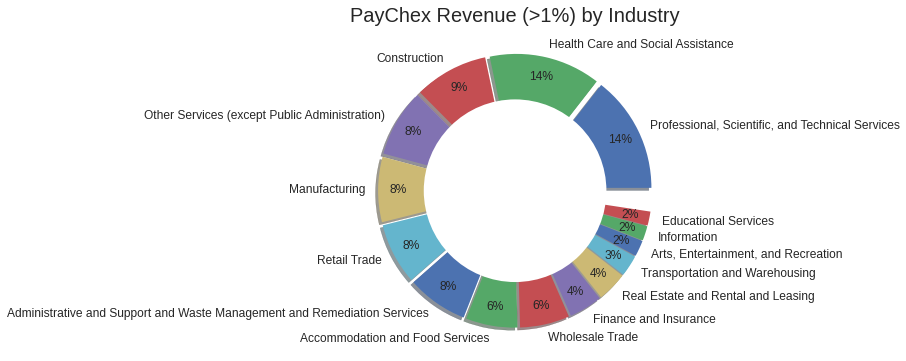

In [ ]:
table_donut(industry, donut_title='PayChex Revenue (>1%) by Industry')

In [ ]:
def yr_table(original_df, group_feature, revenue_type, percentage_threshold):
  ind_cols= ['BUSTYPELEVEL1', 'STATECODE']
  ind_cols.extend([revenue_type])
  strings = original_df.columns.tolist()
  #Total Revenue 
  total_cols = [string for string in strings if "TOTALREV" in string]
  #PAYROLLREV
  payroll_cols = [string for string in strings if "PAYROLLREV" in string]
  #PEOREV
  peo_cols = [string for string in strings if "PEOREV" in string]
  #ASOREV
  aso_cols = [string for string in strings if "ASOREV" in string]
  #TIMEREV
  timer_cols = [string for string in strings if "TIMEREV" in string]
  #RETIREMENTREV
  retire_cols = [string for string in strings if "RETIREMENTREV" in string]
  #HNBREV
  hnb_cols = [string for string in strings if "HNBREV" in string]
  #WRKRSCOMPREV
  wrkscomp_cols = [string for string in strings if "WRKRSCOMPREV" in string]

  original_df['TOTALREV'] = original_df[total_cols].sum(axis=1)
  original_df['Payroll'] = original_df[payroll_cols].sum(axis=1)
  original_df['PEO'] = original_df[peo_cols].sum(axis=1)
  original_df['ASO'] = original_df[aso_cols].sum(axis=1)
  original_df['Timer'] = original_df[timer_cols].sum(axis=1)
  original_df['Retire'] = original_df[retire_cols].sum(axis=1)
  original_df['H&B'] = original_df[hnb_cols].sum(axis=1)
  original_df['WorkComp'] = original_df[wrkscomp_cols].sum(axis=1)

  temp = original_df[ind_cols].groupby([group_feature])[revenue_type].sum()
  new_table = pd.DataFrame(index=temp.index.to_list(), columns=['Revenue', 'Revenue %'])
  new_table['Revenue'] = temp.to_list()
  new_table['Revenue %'] = round(new_table['Revenue']/sum(temp.to_list()), 3)
  new_table = new_table[new_table['Revenue %']>percentage_threshold].sort_values(by='Revenue %', ascending=False)
  # explode = [0.05] * len(new_table)
  return new_table

In [ ]:
industry_18_total = yr_table(original_df=px_18, group_feature='BUSTYPELEVEL1', revenue_type='TOTALREV', percentage_threshold=0.01)
industry_19_total = yr_table(original_df=px_19, group_feature='BUSTYPELEVEL1', revenue_type='TOTALREV', percentage_threshold=0.01)
industry_20_total = yr_table(original_df=px_20, group_feature='BUSTYPELEVEL1', revenue_type='TOTALREV', percentage_threshold=0.01)
industry_21_total = yr_table(original_df=px_21, group_feature='BUSTYPELEVEL1', revenue_type='TOTALREV', percentage_threshold=0.01)
industry_22_total = yr_table(original_df=px_22, group_feature='BUSTYPELEVEL1', revenue_type='TOTALREV', percentage_threshold=0.01)

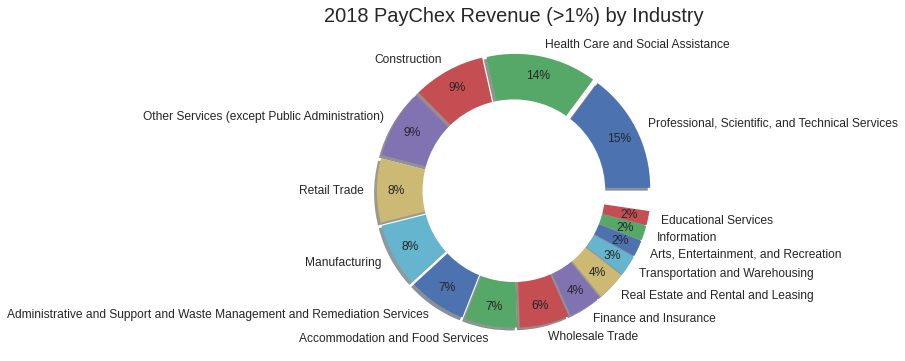

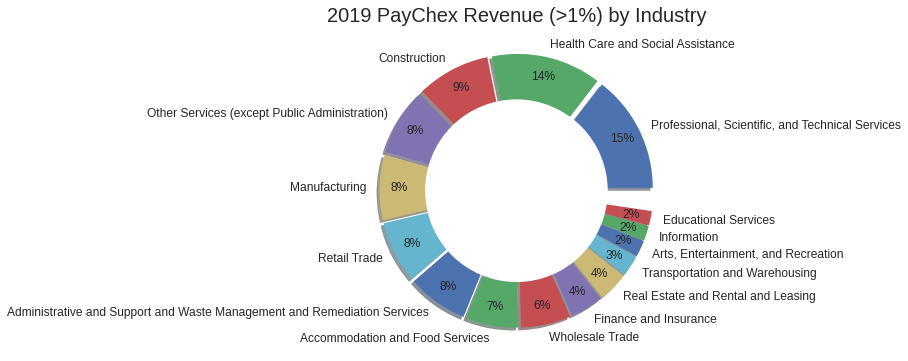

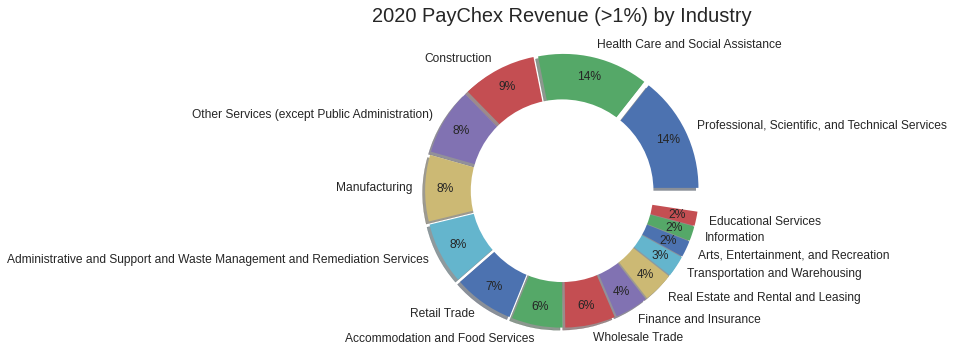

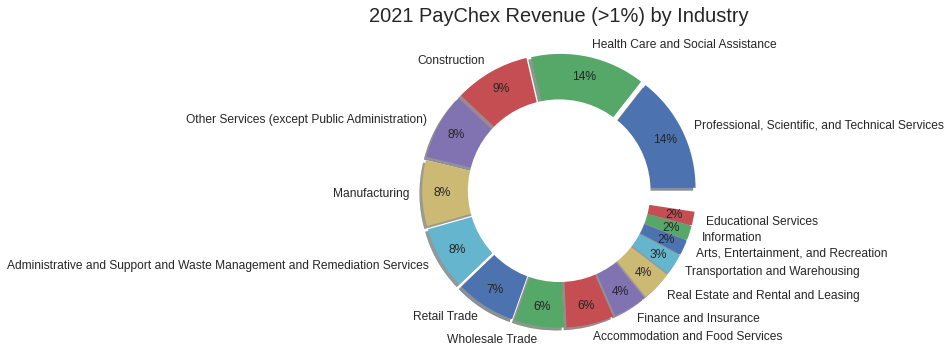

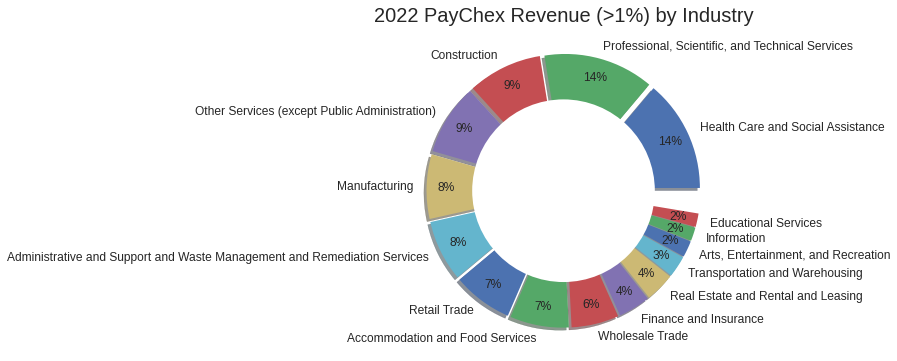

In [ ]:
table_donut(industry_18_total, donut_title='2018 PayChex Revenue (>1%) by Industry')
table_donut(industry_19_total, donut_title='2019 PayChex Revenue (>1%) by Industry')
table_donut(industry_20_total, donut_title='2020 PayChex Revenue (>1%) by Industry')
table_donut(industry_21_total, donut_title='2021 PayChex Revenue (>1%) by Industry')
table_donut(industry_22_total, donut_title='2022 PayChex Revenue (>1%) by Industry')
del industry_18_total, industry_19_total, industry_20_total, industry_21_total, industry_22_total

Payroll by industry

In [ ]:
industry_18_Payroll = yr_table(original_df=px_18, group_feature='BUSTYPELEVEL1', revenue_type='Payroll', percentage_threshold=0.01)
industry_19_Payroll = yr_table(original_df=px_19, group_feature='BUSTYPELEVEL1', revenue_type='Payroll', percentage_threshold=0.01)
industry_20_Payroll = yr_table(original_df=px_20, group_feature='BUSTYPELEVEL1', revenue_type='Payroll', percentage_threshold=0.01)
industry_21_Payroll = yr_table(original_df=px_21, group_feature='BUSTYPELEVEL1', revenue_type='Payroll', percentage_threshold=0.01)
industry_22_Payroll = yr_table(original_df=px_22, group_feature='BUSTYPELEVEL1', revenue_type='Payroll', percentage_threshold=0.01)

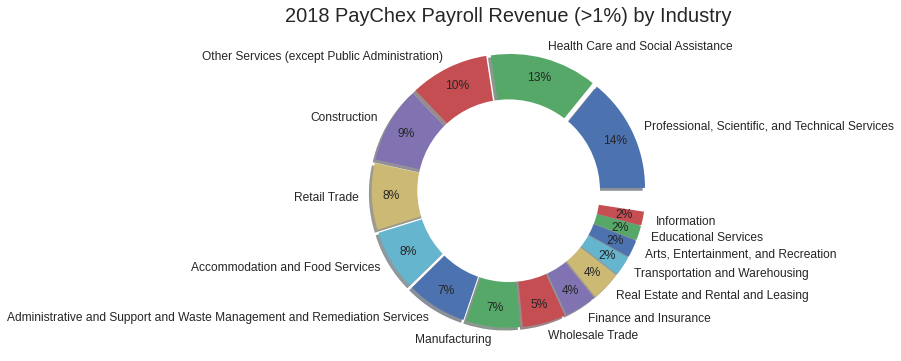

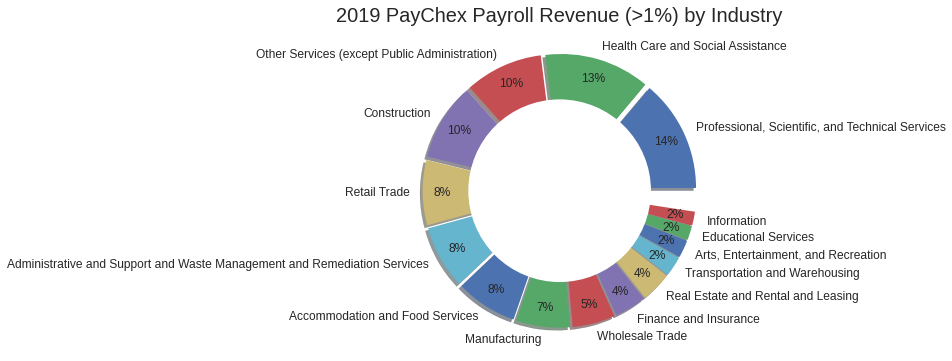

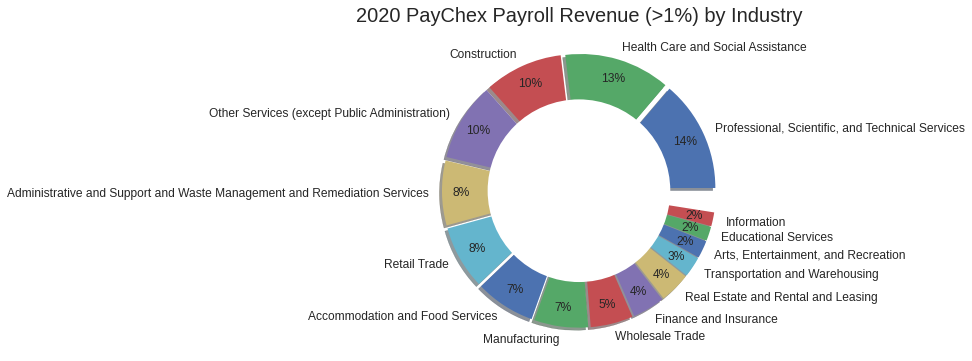

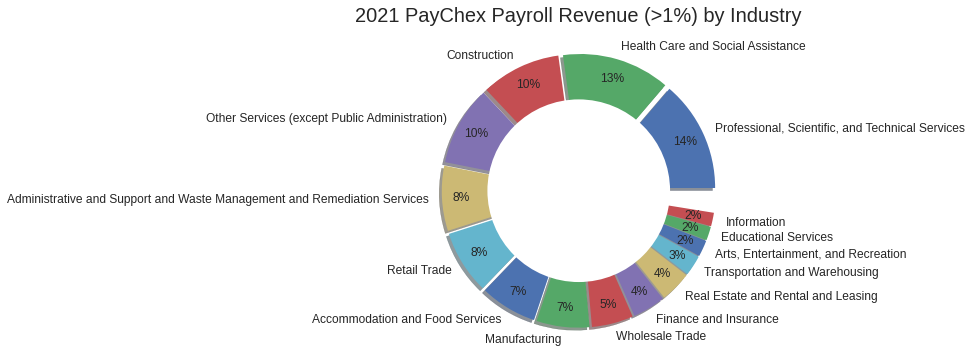

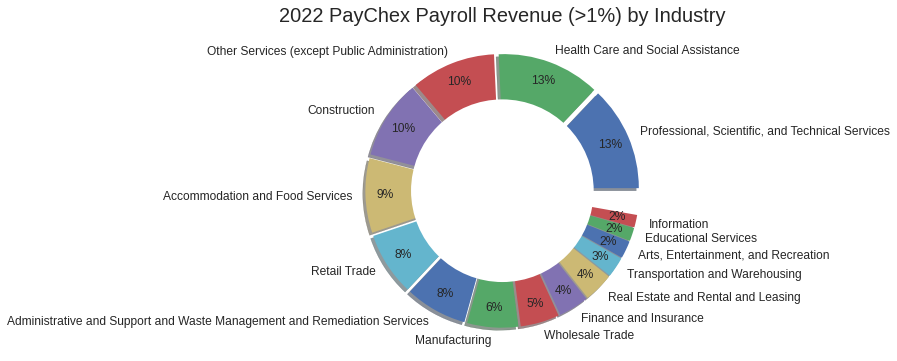

In [ ]:
table_donut(industry_18_Payroll, donut_title='2018 PayChex Payroll Revenue (>1%) by Industry')
table_donut(industry_19_Payroll, donut_title='2019 PayChex Payroll Revenue (>1%) by Industry')
table_donut(industry_20_Payroll, donut_title='2020 PayChex Payroll Revenue (>1%) by Industry')
table_donut(industry_21_Payroll, donut_title='2021 PayChex Payroll Revenue (>1%) by Industry')
table_donut(industry_22_Payroll, donut_title='2022 PayChex Payroll Revenue (>1%) by Industry')

ASO by industry

In [ ]:
industry_18_ASO = yr_table(original_df=px_18, group_feature='BUSTYPELEVEL1', revenue_type='ASO', percentage_threshold=0.01)
industry_19_ASO = yr_table(original_df=px_19, group_feature='BUSTYPELEVEL1', revenue_type='ASO', percentage_threshold=0.01)
industry_20_ASO = yr_table(original_df=px_20, group_feature='BUSTYPELEVEL1', revenue_type='ASO', percentage_threshold=0.01)
industry_21_ASO = yr_table(original_df=px_21, group_feature='BUSTYPELEVEL1', revenue_type='ASO', percentage_threshold=0.01)
industry_22_ASO = yr_table(original_df=px_22, group_feature='BUSTYPELEVEL1', revenue_type='ASO', percentage_threshold=0.01)

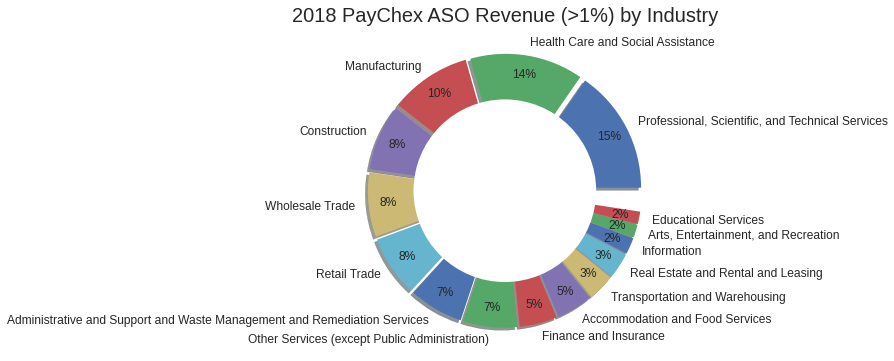

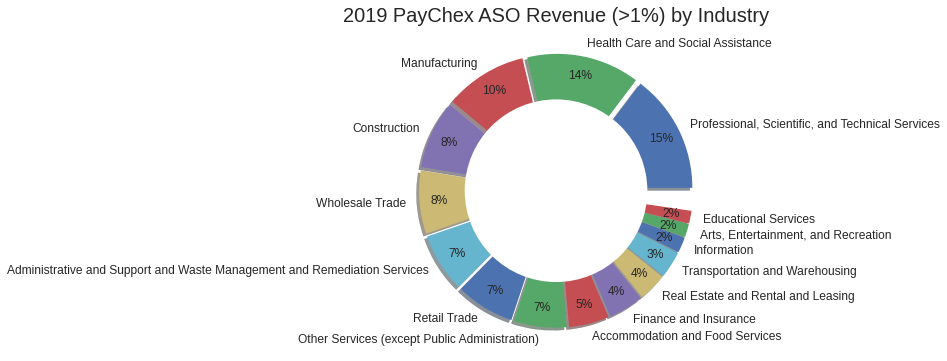

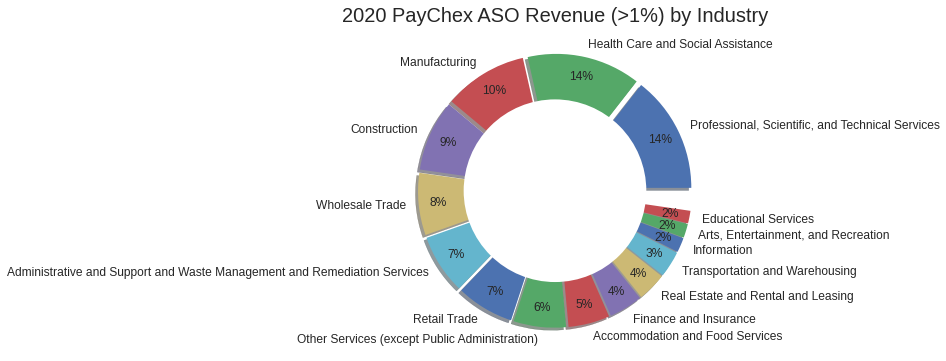

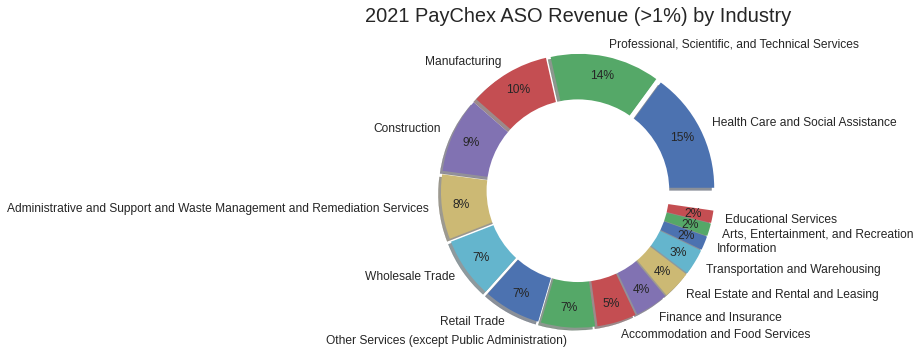

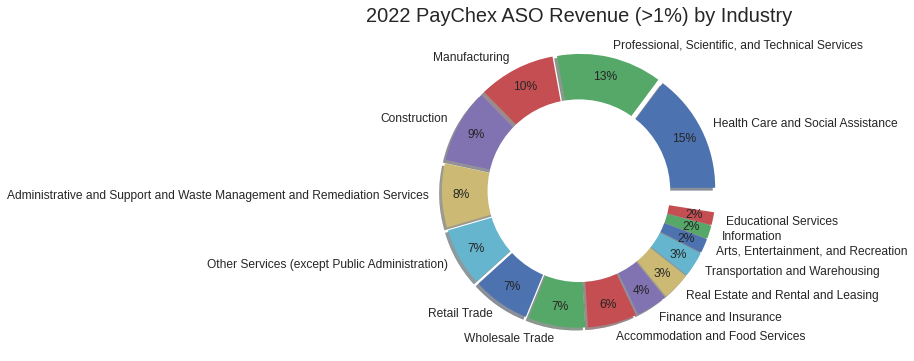

In [ ]:
table_donut(industry_18_ASO, donut_title='2018 PayChex ASO Revenue (>1%) by Industry')
table_donut(industry_19_ASO, donut_title='2019 PayChex ASO Revenue (>1%) by Industry')
table_donut(industry_20_ASO, donut_title='2020 PayChex ASO Revenue (>1%) by Industry')
table_donut(industry_21_ASO, donut_title='2021 PayChex ASO Revenue (>1%) by Industry')
table_donut(industry_22_ASO, donut_title='2022 PayChex ASO Revenue (>1%) by Industry')

State

In [ ]:
state = table4plot(px_total, 'STATECODE', 'TOTALREV', 0.01)
state

,Revenue,Revenue %
CA,222432012401.42%,16.89%
NY,176102506296.79%,13.37%
FL,103331232159.87%,7.85%
NJ,76650124659.97%,5.82%
MA,69244487303.00%,5.26%
PA,59504080089.01%,4.52%
TX,57718804937.04%,4.38%
OH,42870356389.01%,3.26%
MI,40189473118.01%,3.05%
IL,37080373161.01%,2.82%


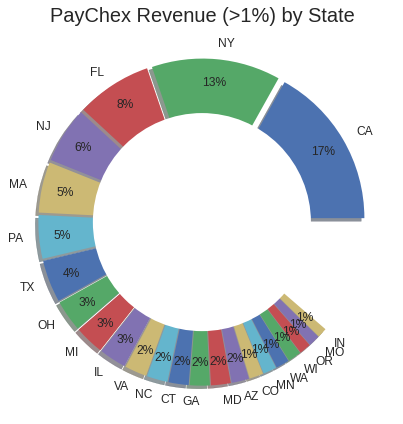

In [ ]:
table_donut(state, donut_title='PayChex Revenue (>1%) by State')

In [ ]:
state2 = table4plot(px_total, 'STATECODE', 'TOTALREV', 0)
state2['Revenue %'] = round(state2['Revenue %'], 3)

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations=state2.index, # Spatial coordinates
    z = state2['Revenue'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "2018-2022 PayChex Revenue by State",
))

# fig.add_scattergeo(
#   locations = state2.index,
#   locationmode = 'USA-states',
#   text = state2['Revenue %'],
#   mode = 'text')


fig.update_layout(
    title_text = '2018-2022 PayChex Revenue by State',
        title={
        'text': "2018-2022 PayChex Revenue by State",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    geo_scope ='usa', # limite map scope to USA
)

fig.show()

In [ ]:
state_18_total = yr_table(original_df=px_18, group_feature='STATECODE', revenue_type='TOTALREV', percentage_threshold=0)
state_19_total = yr_table(original_df=px_19, group_feature='STATECODE', revenue_type='TOTALREV', percentage_threshold=0)
state_20_total = yr_table(original_df=px_20, group_feature='STATECODE', revenue_type='TOTALREV', percentage_threshold=0)
state_21_total = yr_table(original_df=px_21, group_feature='STATECODE', revenue_type='TOTALREV', percentage_threshold=0)
state_22_total = yr_table(original_df=px_22, group_feature='STATECODE', revenue_type='TOTALREV', percentage_threshold=0)

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations=state_19_total.index, # Spatial coordinates
    z = state_19_total['Revenue'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "2019 PayChex Revenue by State",
))

fig.add_scattergeo(
  locations = state_19_total.index,
  locationmode = 'USA-states',
  text = state_19_total['Revenue %'],
  mode = 'text')


fig.update_layout(
    title_text = '2019 PayChex Revenue by Statee',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

Prediction Model


1.   Base model: SARIMA 
2.   Hybrid Model: ThymeBoost
3.   General Additive Model(GAM): FBPhropet



In [ ]:
%%time
px_total = pd.read_parquet("/content/drive/MyDrive/Paycheck Project/px_total.parquet.gzip")

CPU times: user 11.1 s, sys: 1.88 s, total: 12.9 s
Wall time: 11.4 s


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
px_total_ts = px_total.groupby(['Month']).TOTALREV.sum()
px_total_ts = pd.DataFrame(px_total_ts)
# px_total_ts.index=pd.to_datetime(px_total_ts.index)
px_total.set_index('Month')

,UNIQUESYSTEMCLIENTID,EECOUNT,BUSTYPELEVEL1,PRSTATUS,STATECODE,LENGTHOFSERVICE,FIRSTPRRUNDATE,LASTPRRUNDATE,MONTHSWITHREVENUE,TOTALREV
Month,,,,,,,,,,
2017-06-01,9970,27,"Professional, Scientific, and Technical Services",Active,MA,207.90,2004-05-21,2021-09-22,12,188.37
2017-07-01,9970,27,"Professional, Scientific, and Technical Services",Active,MA,207.90,2004-05-21,2021-09-22,12,200.47
2017-08-01,9970,27,"Professional, Scientific, and Technical Services",Active,MA,207.90,2004-05-21,2021-09-22,12,282.62
2017-09-01,9970,27,"Professional, Scientific, and Technical Services",Active,MA,207.90,2004-05-21,2021-09-22,12,195.79
2017-10-01,9970,27,"Professional, Scientific, and Technical Services",Active,MA,207.90,2004-05-21,2021-09-22,12,254.10
...,...,...,...,...,...,...,...,...,...,...
2021-09-01,950636,7,"Professional, Scientific, and Technical Services",Active,FL,184.40,2006-05-09,2021-09-22,4,503.44
2021-06-01,1425449,93,Finance and Insurance,Active,AL,3.20,2021-06-25,2021-09-27,4,"2,648.37"
2021-07-01,1425449,93,Finance and Insurance,Active,AL,3.20,2021-06-25,2021-09-27,4,"1,808.31"


In [ ]:
px_total_ts.index

DatetimeIndex(['2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

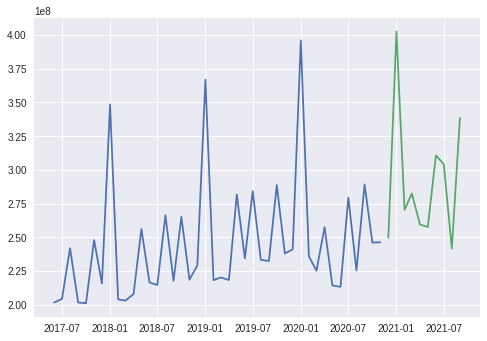

In [ ]:
train=px_total_ts[:42]
test=px_total_ts[42:]
plt.plot(train)
plt.plot(test)

model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

In [ ]:
arima = pm.auto_arima(y=train,
                      start_p=0, d=1, start_q=0, max_p=5, max_q=5, 
                      start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12,
                      seasonal=True, error_action='warn',trace=True, supress_warnings=True,stepwise=False, random_state=20,random=True)
prediction = pd.DataFrame(arima.predict(n_periods = len(test)),index=test.index, columns=test.columns)

 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1104.465, Time=0.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1109.920, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1105.292, Time=0.38 sec
 ARIMA(0,1,4)(0,1,1)[12]             : AIC=1108.911, Time=0.24 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=1109.349, Time=0.68 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1103.507, Time=0.30 sec
 ARIMA(4,1,0)(0,1,1)[12]             : AIC=1110.488, Time=0.17 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1106.550, Time=0.26 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.27 sec

Best model:  ARIMA(2,1,1)(1,1,0)[12]          
Total fit time: 5.333 seconds


In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(test['TOTALREV'], prediction['TOTALREV'])

{'mae': 34517473.19899178,
 'mape': 0.14507526248669983,
 'me': 34517473.19899178,
 'mpe': 0.14507526248669983,
 'rmse': 44590419.869790874}

In [ ]:
print('MAPE:', '{:,.3f}'.format(mean_absolute_percentage_error(test['TOTALREV'], prediction['TOTALREV'])))
print('MAE:', '{:,.2f}'.format(mean_absolute_error(test['TOTALREV'], prediction['TOTALREV'])))
print('RMSE:', '{:,.2f}'.format(mean_squared_error(test['TOTALREV'], prediction['TOTALREV'])**0.5))

MAPE: 0.116
MAE: 34,517,473.20
RMSE: 44,590,419.87


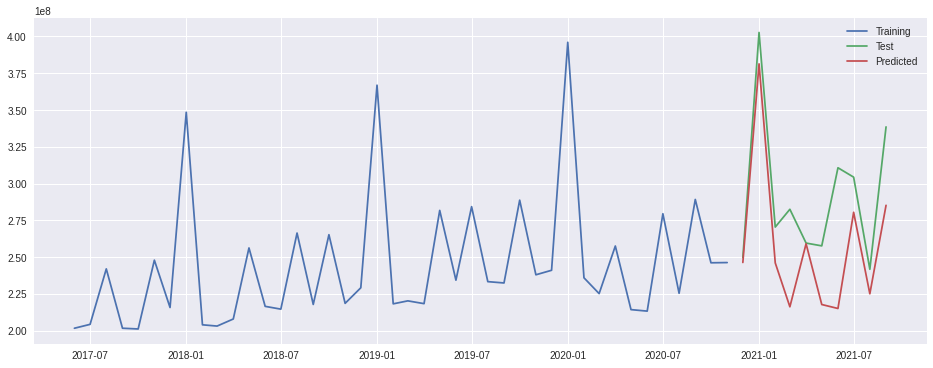

In [ ]:
prediction.columns = ['TOTALREV']
plt.figure(figsize=(16,6))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper right')
plt.show()

FBPhropet

In [ ]:
pip install fbprophet

In [ ]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [ ]:
temp4 = pd.read_excel('/content/drive/MyDrive/Paycheck Project/All_industry_with_last_6months_Complete.xlsx')
temp4.columns = ['ds', 'y', 'Job openings rate', 'Hiring rate', 'Total seperations rate', 'Unemployment rate', 'Inflation rate']
temp4 = temp4.drop(index=[51, 52])
train_X= temp4[:42]
test_X= temp4[42:]

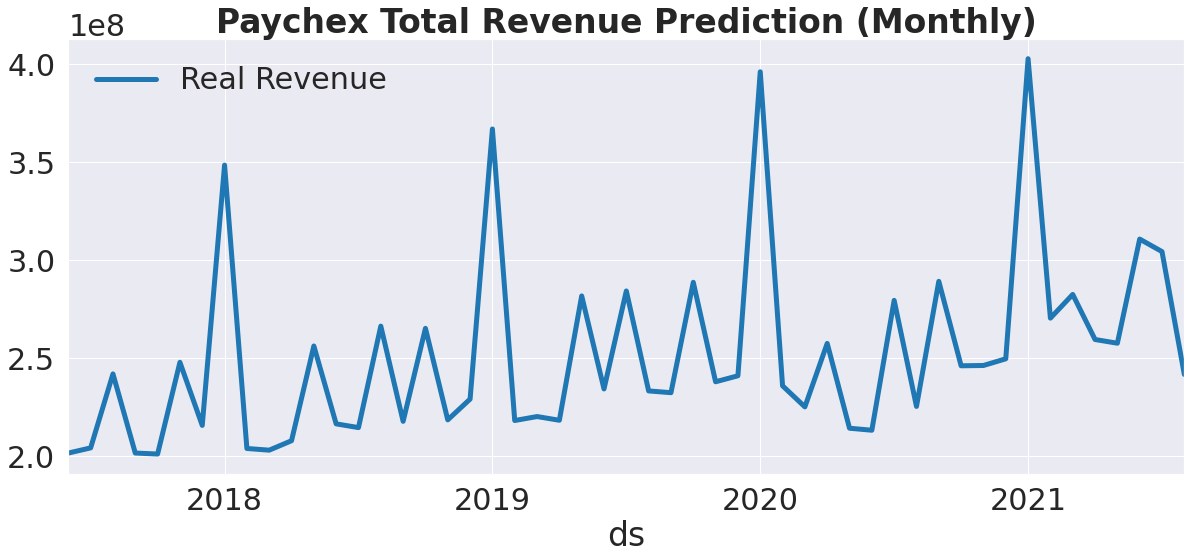

In [ ]:
sns.set(rc={'figure.figsize':(20,8)})
sns.set(font_scale = 2.75)
ax = temp4['y'].plot(label="Real Revenue", color='tab:blue', linewidth = 5)
ax.set_title("Paychex Total Revenue Prediction (Monthly)", weight='bold')
plt.legend()
plt.show()

Without indicating peak period during forecast period

In [ ]:
# add holydays/peak days
peak_season = pd.DataFrame({
  'holiday': 'peak_season',
  'ds': pd.to_datetime(['2017-08-01', '2017-11-01',
                        '2018-01-01', '2018-05-01',
                        '2018-08-01', '2018-10-01',
                        '2019-01-01', '2019-05-01', 
                        '2019-07-01', '2019-10-01',
                        '2020-01-01', '2019-07-01',
                        '2020-09-01']),
  'lower_window': 0,
  'upper_window': 0,
})
#Additional Regressor
pro_regressor= Prophet(holidays=peak_season)
pro_regressor.add_regressor('Job openings rate')
pro_regressor.add_regressor('Hiring rate')
pro_regressor.add_regressor('Total seperations rate')
pro_regressor.add_regressor('Unemployment rate')
pro_regressor.add_regressor('Inflation rate')
#Fitting the data
pro_regressor.fit(train_X)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = pro_regressor.make_future_dataframe(periods=24)
forecast = pro_regressor.predict(test_X)

In [ ]:
print('MAPE:', '{:,.3f}'.format(mean_absolute_percentage_error(test_X['y'], forecast['yhat'])))
print('MAE:', '{:,.2f}'.format(mean_absolute_error(test_X['y'], forecast['yhat'])))
print('RMSE:', '{:,.2f}'.format(mean_squared_error(test_X['y'], forecast['yhat'])**0.5))

MAPE: 0.092
MAE: 27,504,881.96
RMSE: 32,392,865.25


In [ ]:
temp4.columns

Index(['y', 'Job openings rate', 'Hiring rate', 'Total seperations rate',
       'Unemployment rate', 'Inflation rate'],
      dtype='object')

In [ ]:
forecast = forecast.set_index('ds')

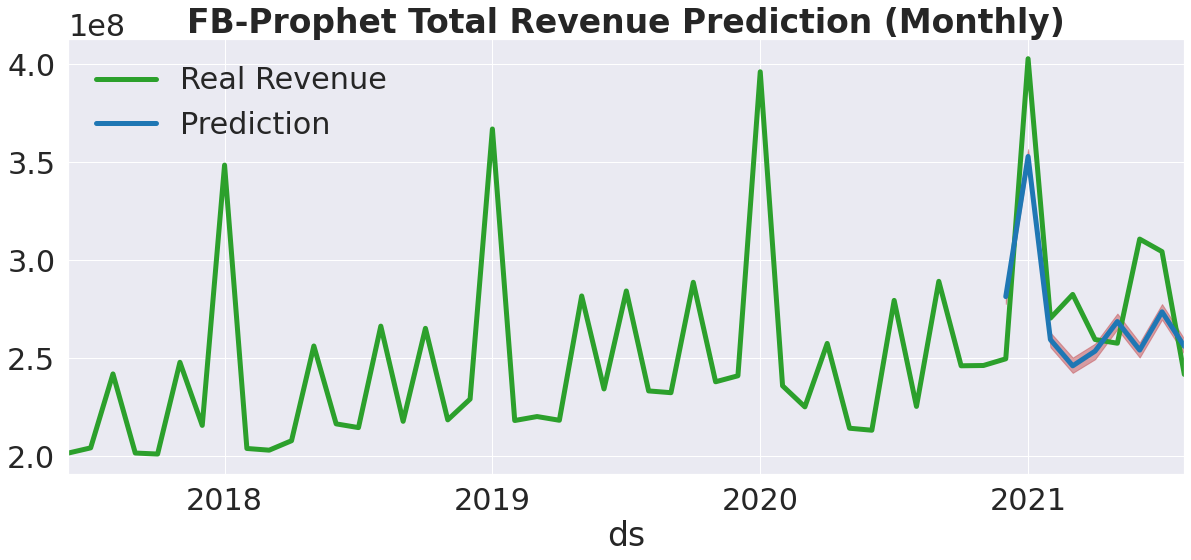

In [ ]:
sns.set(rc={'figure.figsize':(20,8)})
sns.set(font_scale = 2.75)

ax = temp4['y'].plot(label="Real Revenue", color='tab:green', linewidth = 5)

forecast['yhat'].plot(ax=ax, label='Prediction', color='tab:blue', linewidth = 5)
ax.fill_between(forecast.index,
                forecast['yhat_upper'],
                forecast['yhat_lower'], color='r', alpha=0.5)
ax.set_title("FB-Prophet Total Revenue Prediction (Monthly)", weight='bold')
plt.legend()
plt.show()

In [ ]:
Indicate peak period during forecast period

In [ ]:
# add holydays/peak days
peak_season = pd.DataFrame({
  'holiday': 'peak_season',
  'ds': pd.to_datetime(['2017-08-01', '2017-11-01',
                        '2018-01-01', '2018-05-01',
                        '2018-08-01', '2018-10-01',
                        '2019-01-01', '2019-05-01', 
                        '2019-07-01', '2019-10-01',
                        '2020-01-01', '2019-07-01',
                        '2020-09-01', '2021-01-01',
                        '2021-03-01', '2021-06-01',
                        '2021-07-01', '2021-09-01']),
  'lower_window': 0,
  'upper_window': 0,
})
#Additional Regressor
pro_regressor= Prophet(holidays=peak_season)
pro_regressor.add_regressor('Job openings rate')
pro_regressor.add_regressor('Hiring rate')
pro_regressor.add_regressor('Total seperations rate')
pro_regressor.add_regressor('Unemployment rate')
pro_regressor.add_regressor('Inflation rate')
#Fitting the data
pro_regressor.fit(train_X)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = pro_regressor.make_future_dataframe(periods=24)
forecast = pro_regressor.predict(test_X)

In [ ]:
print('MAPE:', '{:,.3f}'.format(mean_absolute_percentage_error(test_X['y'], forecast['yhat'])))
print('MAE:', '{:,.2f}'.format(mean_absolute_error(test_X['y'], forecast['yhat'])))
print('RMSE:', '{:,.2f}'.format(mean_squared_error(test_X['y'], forecast['yhat'])**0.5))

MAPE: 0.049
MAE: 13,330,740.15
RMSE: 15,976,486.85


In [ ]:
temp4 = temp4.set_index('ds')

In [ ]:
forecast = forecast.set_index('ds')

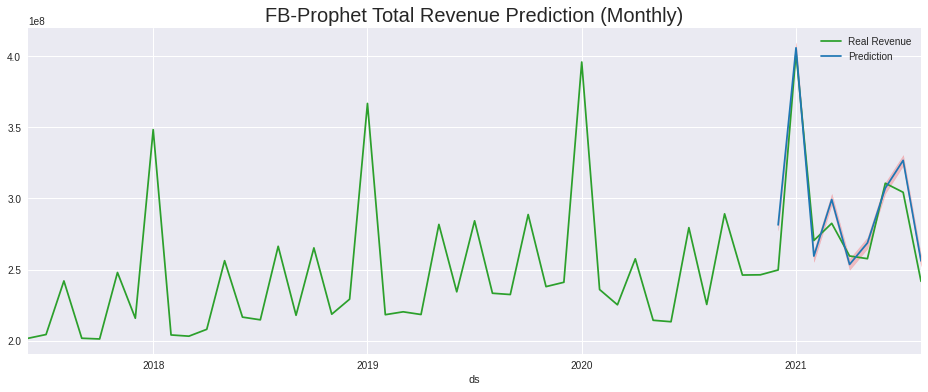

In [ ]:
sns.set(rc={'figure.figsize':(20,8)})
sns.set(font_scale = 2.75)
ax = temp4['y'].plot(label="Real Revenue", color='tab:green')
forecast['yhat'].plot(ax=ax, label='Prediction',  figsize=(16, 6), color='tab:blue')
ax.fill_between(forecast.index,
                forecast['yhat_upper'],
                forecast['yhat_lower'], color='r', alpha=.2)
ax.set_title("FB-Prophet Total Revenue Prediction (Monthly)", fontsize=20)
plt.legend()
plt.show()

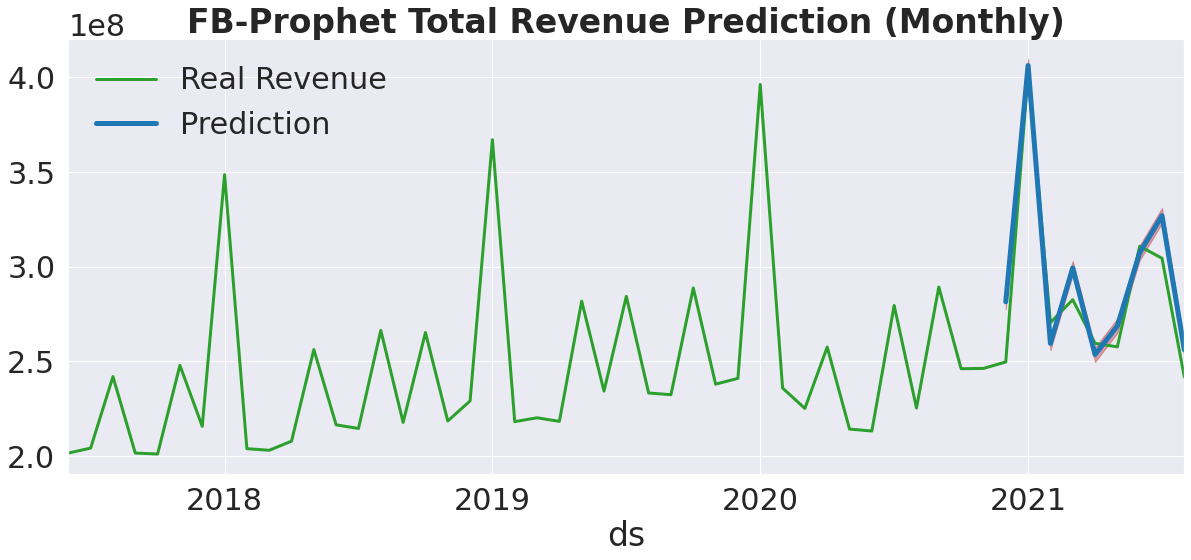

In [ ]:
sns.set(rc={'figure.figsize':(20,8)})
sns.set(font_scale = 2.75)

ax = temp4['y'].plot(label="Real Revenue", color='tab:green', linewidth = 3)

forecast['yhat'].plot(ax=ax, label='Prediction', color='tab:blue', linewidth = 5)
ax.fill_between(forecast.index,
                forecast['yhat_upper'],
                forecast['yhat_lower'], color='r', alpha=0.5)
ax.set_title("FB-Prophet Total Revenue Prediction (Monthly)", weight='bold')
plt.legend()
plt.show()

ThymeBoost

In [ ]:
pip install ThymeBoost

In [ ]:
from ThymeBoost import ThymeBoost as tb

In [ ]:
temp4 = pd.read_excel('/content/drive/MyDrive/Paycheck Project/All_industry_with_last_6months_Complete.xlsx')
temp4.columns = ['ds', 'y', 'Job openings rate', 'Hiring rate', 'Total seperations rate', 'Unemployment rate', 'Inflation rate']
temp4 = temp4.drop(index=[51, 52])
temp4 = temp4.set_index('ds')
train_X= temp4[:42]
test_X= temp4[42:]

In [ ]:
train_X

In [ ]:
boosted_model = tb.ThymeBoost(approximate_splits=False, verbose=0, cost_penalty=.001)
output = boosted_model.fit(train_X['y'],
                           trend_estimator='linear',
                           seasonal_estimator='fourier',
                          #  exogenous_estimator='ols',
                           seasonal_period=[12, 3],
                           split_cost='mse',
                           global_cost='maicc',
                           fit_type='global')
predicted_output = boosted_model.predict(output, len(test_X))

In [ ]:
print('MAPE:', '{:,.3f}'.format(mean_absolute_percentage_error(test_X['y'], predicted_output['predictions'])))
print('MAE:', '{:,.2f}'.format(mean_absolute_error(test_X['y'], predicted_output['predictions'])))
print('RMSE:', '{:,.2f}'.format(mean_squared_error(test_X['y'], predicted_output['predictions'])**0.5))

MAPE: 0.093
MAE: 26,501,823.07
RMSE: 32,358,039.78


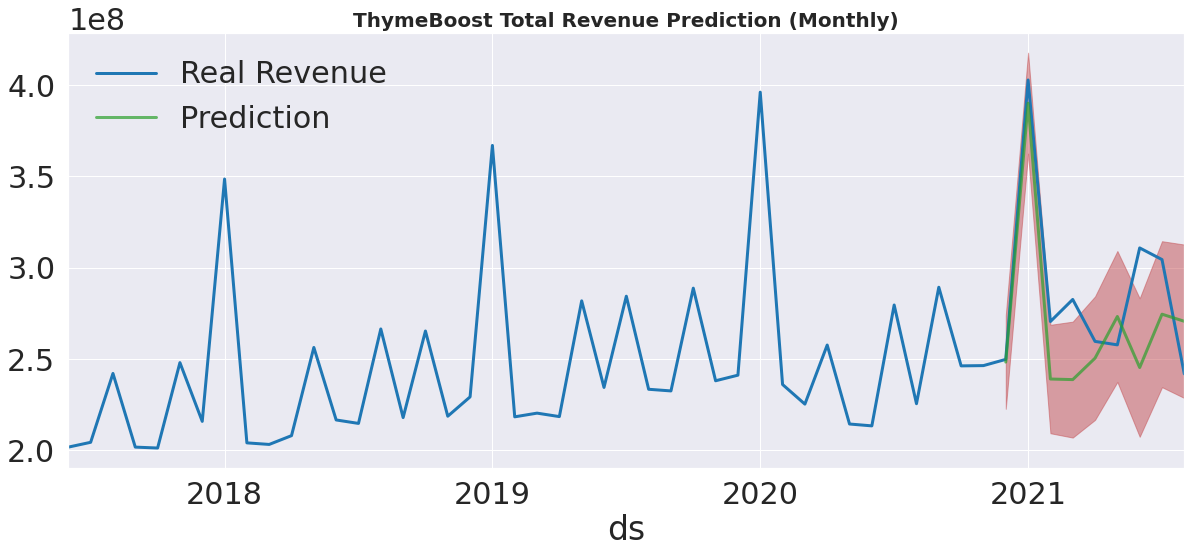

In [ ]:
sns.set(rc={'figure.figsize':(20,8)})
sns.set(font_scale = 2.75)
ax = temp4['y'].plot(label="Real Revenue", color='tab:blue', linewidth = 3)

predicted_output['predictions'].plot(ax=ax, label='Prediction', alpha=.7, color='tab:green', linewidth = 3)
ax.fill_between(predicted_output.index,
                predicted_output['predicted_upper'],
                predicted_output['predicted_lower'], color='r', alpha=.5)
ax.set_title("ThymeBoost Total Revenue Prediction (Monthly)", fontsize=20, weight='bold')
plt.legend()
plt.show()

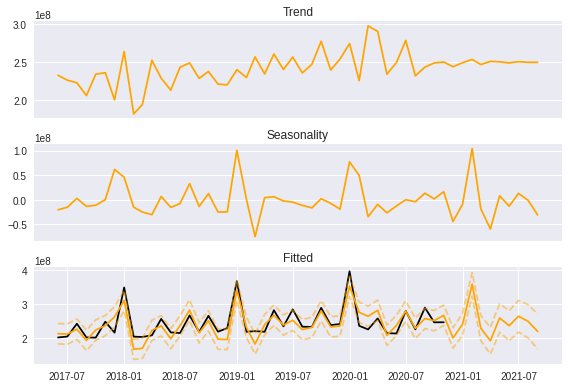

In [ ]:
boosted_model.plot_components(output, predicted_output)

In [ ]:
boosted_model = tb.ThymeBoost(approximate_splits=False, verbose=0, cost_penalty=.001)
output = boosted_model.fit(train_X['y'],
                           trend_estimator=['ransac'] + ['linear']*10,
                           seasonal_estimator='fourier',
                           exogenous_estimator='ols',
                           seasonal_period=[12, 4],
                           split_cost='mse',
                           global_cost='maicc',
                           fit_type='global')
predicted_output = boosted_model.predict(output, len(test_X))

In [ ]:
print('MAPE:', '{:,.3f}'.format(mean_absolute_percentage_error(test_X['y'], predicted_output['predictions'])))
print('MAE:', '{:,.2f}'.format(mean_absolute_error(test_X['y'], predicted_output['predictions'])))
print('RMSE:', '{:,.2f}'.format(mean_squared_error(test_X['y'], predicted_output['predictions'])**0.5))

MAPE: 0.090
MAE: 25,732,978.93
RMSE: 31,814,025.77


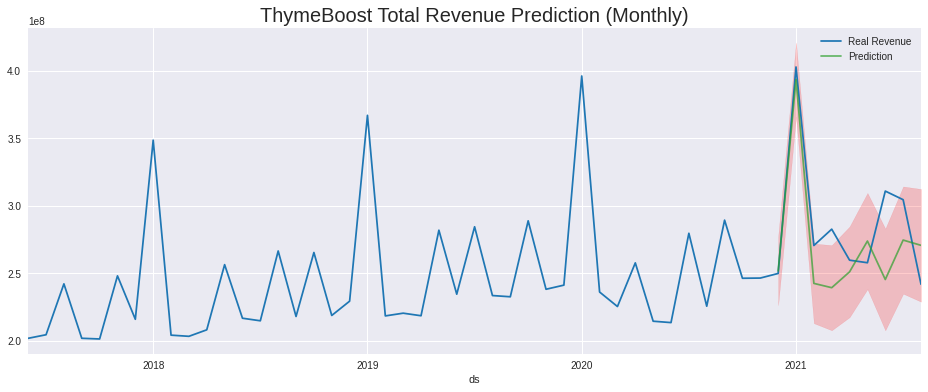

In [ ]:
ax = temp4['y'].plot(label="Real Revenue", color='tab:blue')

predicted_output['predictions'].plot(ax=ax, label='Prediction', alpha=.7, figsize=(16, 6), color='tab:green')
ax.fill_between(predicted_output.index,
                predicted_output['predicted_upper'],
                predicted_output['predicted_lower'], color='r', alpha=.2)
ax.set_title("ThymeBoost Total Revenue Prediction (Monthly)", fontsize=20)
plt.legend()
plt.show()

In [ ]:
boosted_model = tb.ThymeBoost(approximate_splits=False, verbose=0, cost_penalty=.001)
output = boosted_model.fit(train_X['y'],
                           trend_estimator = 'ar',
                            arima_order = [(2,1,1)],
                           seasonal_estimator='fourier',
                           exogenous_estimator='ols',
                           seasonal_period=[12, 4],
                           split_cost='mse',
                           global_cost='maicc',
                           fit_type='global')
predicted_output = boosted_model.predict(output, len(test_X))

NotImplementedError: ignored

In [ ]:
print('MAPE:', '{:,.3f}'.format(mean_absolute_percentage_error(test_X['y'], predicted_output['predictions'])))
print('MAE:', '{:,.2f}'.format(mean_absolute_error(test_X['y'], predicted_output['predictions'])))
print('RMSE:', '{:,.2f}'.format(mean_squared_error(test_X['y'], predicted_output['predictions'])**0.5))

MAPE: 0.090
MAE: 25,732,978.93
RMSE: 31,814,025.77


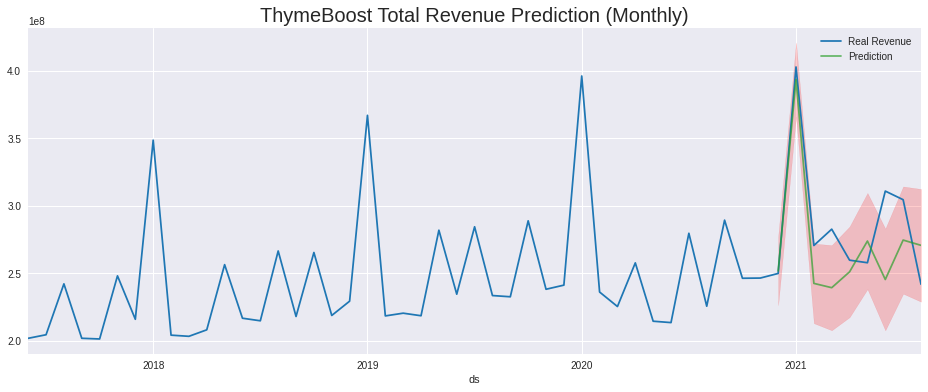

In [ ]:
ax = temp4['y'].plot(label="Real Revenue", color='tab:blue')

predicted_output['predictions'].plot(ax=ax, label='Prediction', alpha=.7, figsize=(16, 6), color='tab:green')
ax.fill_between(predicted_output.index,
                predicted_output['predicted_upper'],
                predicted_output['predicted_lower'], color='r', alpha=.2)
ax.set_title("ThymeBoost Total Revenue Prediction (Monthly)", fontsize=20)
plt.legend()
plt.show()